In [1]:
using JLD2, FileIO
using Quaternions
using LinearAlgebra
using Statistics
using PyPlot
using Random
using ProgressMeter
include("QRPNN.jl")
rng = MersenneTwister(1234);

In [2]:
N = 100;
K = 32;
tau = 1.e-4;

In [3]:
# Parameters;
L = 3.0;
alpha = 15.0;
q = 20.0;
it_max = 1.e+3

params=[nothing,alpha,L,q]
fs = [QRPNN.identity, QRPNN.exponential, QRPNN.potential, QRPNN.high_order];

In [4]:
Smax = 100
pr = Array{Float64}(0.0:0.05:1.0)
PrRecall = zeros(Int64,(10,length(pr)))

@showprogress for s = 1:Smax
    # Generate the fundamental memories
    U = Array{Quaternion{Float64}}(undef,(N,K))
    for i = 1:N
        for j = 1:K
            phi = pi*2*rand(1)[1]-1
            psi = pi*(2*rand(1)[1]-1)/4
            theta = pi*(2*rand(1)[1]-1)/2
            U[i,j] = Quaternion(cos(phi),sin(phi),0,0)*Quaternion(cos(psi),0,0,sin(psi))*Quaternion(cos(theta),0,sin(theta),0)
        end
    end

    # Train the projection models
    Vs = []
    for j=1:4
        push!(Vs,QRPNN.train(fs[j],params[j],U))
    end
    
    # Projection and correlation
    Uc = U'/(4*N)
    Up = (inv((U'*U)/N)*U')/N
    
    for i = 1:length(pr)
        # Generate a corrupted version of a fundamental memory
        x = copy(U[:,1])
        for j = 1:N
            if rand(1)[1]<pr[i]
                phi = pi*2*rand(1)[1]-1
                psi = pi*(2*rand(1)[1]-1)/4
                theta = pi*(2*rand(1)[1]-1)/2
                x[j] = Quaternion(cos(phi),sin(phi),0,0)*Quaternion(cos(psi),0,0,sin(psi))*Quaternion(cos(theta),0,sin(theta),0)
            end
        end 
        
        #
        # Hopfield
        #
        y = QRPNN.hopfield(U, Uc, x, it_max, false)
        PrRecall[1,i] = PrRecall[1,i]+(norm(U[:,1]-y)<tau)
        #
        y = QRPNN.hopfield(U, Up, x, it_max, false)
        PrRecall[2,i] = PrRecall[2,i]+(norm(U[:,1]-y)<tau)
        
        
        #
        # QRCNN
        #
        for j=1:4
            y = QRPNN.main(fs[j],params[j], U, U, x, it_max, false)
            PrRecall[2+j,i] = PrRecall[2+j,i]+(norm(U[:,1]-y)<tau)
        end
        
        #
        # QRPNN
        #
        for j=1:4
            y = QRPNN.main(fs[j],params[j], U, Vs[j], x, it_max, false)
            PrRecall[6+j,i] = PrRecall[6+j,i]+(norm(U[:,1]-y)<tau)
        end
    end
    @save "JLDs/Example2.jld2" pr PrRecall Smax
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:14


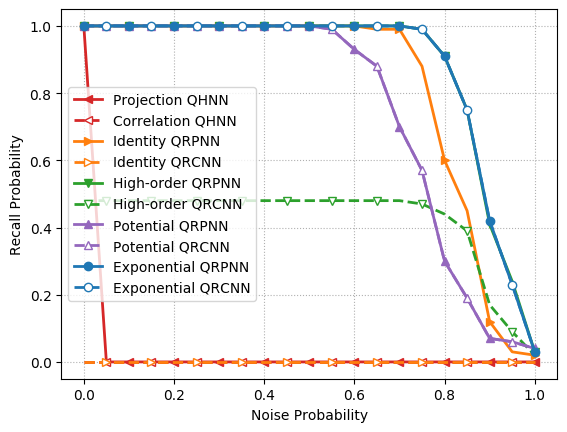

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [5]:
@load "JLDs/Example2.jld2"
plot(pr,PrRecall[2,:]/Smax,linewidth=2,color="#d62728",marker="<",markevery=(0,2),label="Projection QHNN")
plot(pr,PrRecall[1,:]/Smax,linewidth=2,color="#d62728",marker="<",markevery=(1,2),mfc="white",linestyle="dashed",label="Correlation QHNN")
plot(pr,PrRecall[7,:]/Smax,linewidth=2.0,color="#ff7f0e",marker=">",markevery=(0,2),label="Identity QRPNN")
plot(pr,PrRecall[3,:]/Smax,linewidth=2,color="#ff7f0e",marker=">",markevery=(1,2),mfc="white",linestyle="dashed",label="Identity QRCNN")
plot(pr,PrRecall[10,:]/Smax,linewidth=2,color="#2ca02c",marker="v",markevery=(0,2),label="High-order QRPNN")
plot(pr,PrRecall[6,:]/Smax,linewidth=2,color="#2ca02c",marker="v",markevery=(1,2),mfc="white",linestyle="dashed",label="High-order QRCNN")
plot(pr,PrRecall[9,:]/Smax,linewidth=2,color="#9467bd",marker="^",markevery=(0,2),label="Potential QRPNN")
plot(pr,PrRecall[5,:]/Smax,linewidth=2,color="#9467bd",marker="^",markevery=(1,2),mfc="white",linestyle="dashed",label="Potential QRCNN")
plot(pr,PrRecall[8,:]/Smax,linewidth=2,color="#1f77b4",marker="o",markevery=(0,2),label="Exponential QRPNN")
plot(pr,PrRecall[4,:]/Smax,linewidth=2,color="#1f77b4",marker="o",markevery=(1,2),mfc="white",linestyle="dashed",label="Exponential QRCNN")
grid(linestyle="dotted")
xlabel("Noise Probability")
ylabel("Recall Probability")
legend()
savefig("Figures/Example2.eps")
savefig("Figures/Example2.pdf")